In [1]:
import pickle
import os
# import torch
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statistics import mean

# jupyter notebook display setting for all data structures
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# load the dictionary of dictionaries from a pickle file
with open('../../data/gcPBM_data/panset.pkl', 'rb') as handle:
    panset = pickle.load(handle)

In [4]:
# load the new feature dictionaries
with open('/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_features/compiled_bubble_data/mad.pkl', 'rb') as handle:
    mad_features = pickle.load(handle)
with open('/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_features/compiled_bubble_data/max.pkl', 'rb') as handle:
    max_features = pickle.load(handle)
with open('/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_features/compiled_bubble_data/myc.pkl', 'rb') as handle:
    myc_features = pickle.load(handle)

In [5]:
mad_data = panset['mad']
max_data = panset['max']
myc_data = panset['myc']

In [6]:
# collapse the train and test partitions into one
mad = {}
for key in mad_data.keys():
    data = mad_data[key]
    for key in data.keys():
        mad[key] = data[key]
mad_data = mad.copy()
max = {}
for key in max_data.keys():
    data = max_data[key]
    for key in data.keys():
        max[key] = data[key]
max_data = max.copy()
myc = {}
for key in myc_data.keys():
    data = myc_data[key]
    for key in data.keys():
        myc[key] = data[key]
myc_data = myc.copy()

In [7]:
# replace the old feature dictionaries with the new ones
y_slice = 10
z_slice = 6
mad = {}
for key in mad_data.keys():
    data = mad_data[key]
    features = mad_features[str(key)]
    mad[key] = {'seq': data['seq'], 'label': data['label'], 'bubble': features['bubbles'][4:40,y_slice,z_slice]/80000, 'flipping': features['flip'][4:40]/80000, 'coords': features['coord'][4:40]/80000, 'coordssquared': features['coord_squared'][4:40]/80000}
mad_data = mad.copy()
max = {}
for key in max_data.keys():
    data = max_data[key]
    features = max_features[str(key)]
    max[key] = {'seq': data['seq'], 'label': data['label'], 'bubble': features['bubbles'][4:40,y_slice,z_slice]/80000, 'flipping': features['flip'][4:40]/80000, 'coords': features['coord'][4:40]/80000, 'coordssquared': features['coord_squared'][4:40]/80000}
max_data = max.copy()
myc = {}
for key in myc_data.keys():
    data = myc_data[key]
    features = myc_features[str(key)]
    myc[key] = {'seq': data['seq'], 'label': data['label'], 'bubble': features['bubbles'][4:40,y_slice,z_slice]/80000, 'flipping': features['flip'][4:40]/80000, 'coords': features['coord'][4:40]/80000, 'coordssquared': features['coord_squared'][4:40]/80000}
myc_data = myc.copy()

In [8]:
# extract the sequence ids from the data
mad_ids = [seq for seq in mad_data.keys()]
max_ids = [seq for seq in max_data.keys()]
myc_ids = [seq for seq in myc_data.keys()]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


10.1485491391513


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


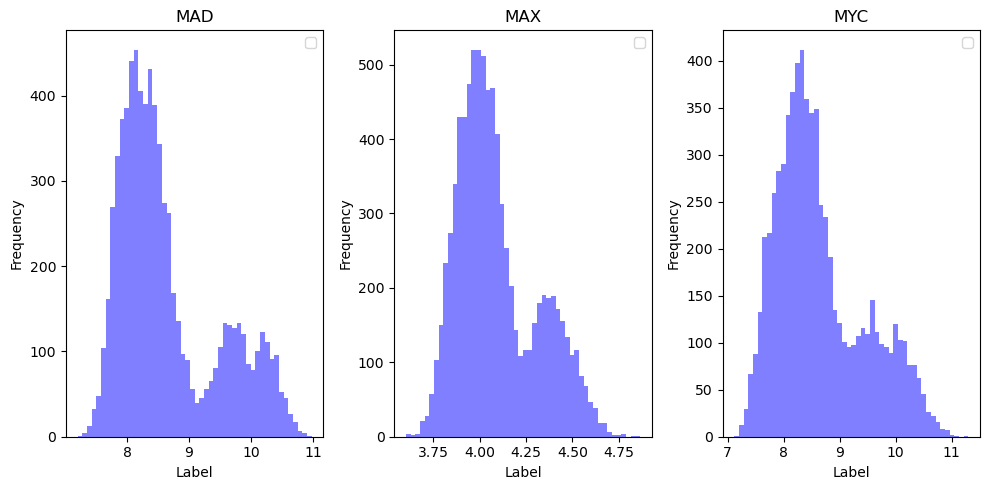

In [9]:
# display label data for 1 sequence
print(mad_data[mad_ids[3]]['label'])

# build a list containing all the labels in mad_data
mad_labels = []
for i in mad_ids:
    mad_labels.append(mad_data[i]['label'])

# build a list containing all the labels in max_data
max_labels = []
for i in max_ids:
    max_labels.append(max_data[i]['label'])

# build a list containing all the labels in myc_data
myc_labels = []
for i in myc_ids:
    myc_labels.append(myc_data[i]['label'])

# plot the label distributions for each TF
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.hist(mad_labels, bins=50, color='blue', alpha=0.5)
plt.title('MAD')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(max_labels, bins=50, color='blue', alpha=0.5)
plt.title('MAX')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(myc_labels, bins=50, color='blue', alpha=0.5)
plt.title('MYC')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# print out the bubble value for 1 sequence
print(mad_data[mad_ids[3]]['bubble'].shape)

(36,)


In [11]:
agnosticset = {}
for tf in [mad_data, max_data, myc_data]:
    if tf == mad_data:
        name = 'mad'
    elif tf == max_data:
        name = 'max'
    else:
        name = 'myc'
    for seq_id in tf.keys():
        agnosticset[f'{name}_{seq_id}'] = tf[seq_id]['bubble']

In [12]:
bubble_max = {}
for n, i in enumerate(agnosticset.keys()):
    bubble_max[n] = {i: agnosticset[i].max()}

In [13]:
# Get the highest values and their associated keys
highest_values = sorted(bubble_max.items(), key=lambda x: list(x[1].values())[0], reverse=True)[:2]
for n, item in highest_values:
    max_key = list(item.keys())[0]
    max_value = list(item.values())[0]

In [14]:
# Get the lowest values and their associated keys
lowest_values = sorted(bubble_max.items(), key=lambda x: list(x[1].values())[0], reverse=False)[:2]
for n, item in highest_values:
    min_key = list(item.keys())[0]
    min_value = list(item.values())[0]

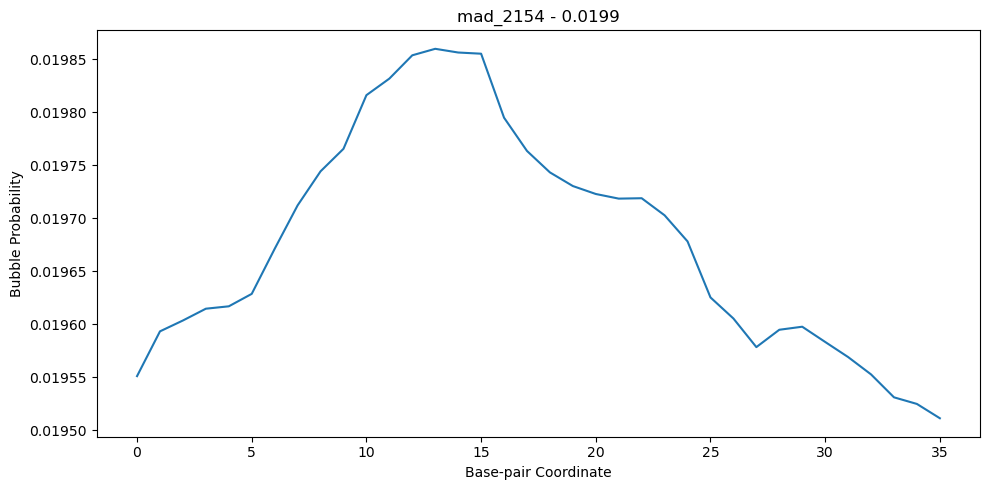

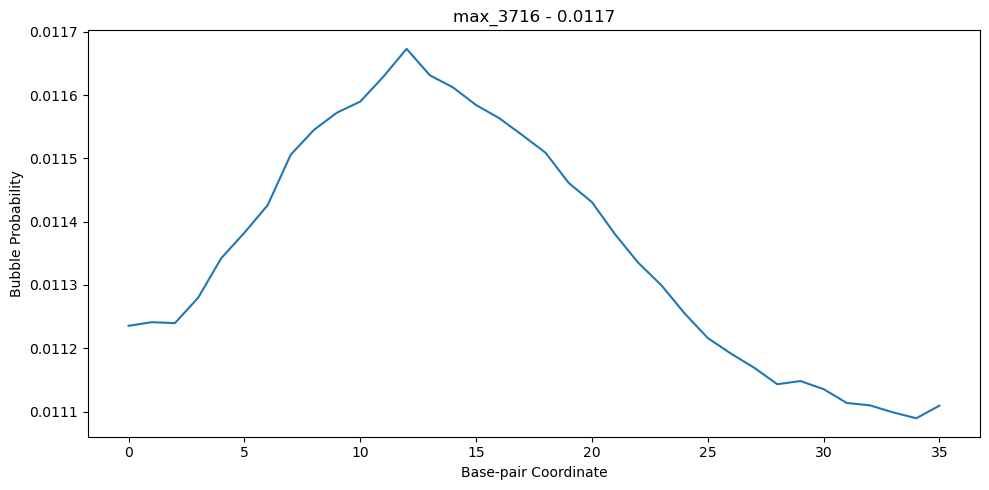

In [15]:
for n, item in highest_values:
    max_key = list(item.keys())[0]
    max_value = list(item.values())[0]
    max_value_formatted = "{:.4f}".format(max_value)  # Restrict to 4 decimal places
    plt.figure(figsize=(10, 5))
    # plot a line curve
    plt.plot(agnosticset[max_key])
    plt.title(f'{max_key} - {max_value_formatted}')
    plt.xlabel('Base-pair Coordinate')
    plt.ylabel('Bubble Probability')
    # remove whitespace from the figure
    plt.tight_layout()
    plt.show()

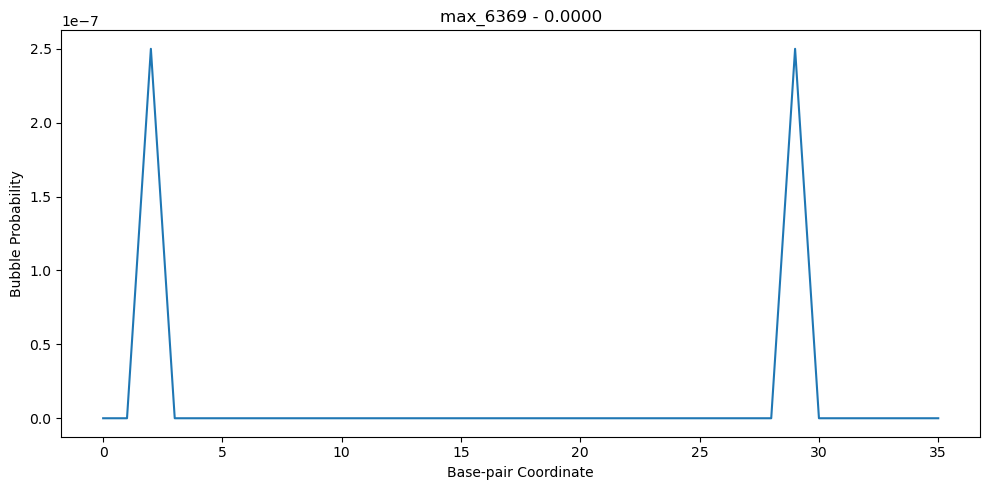

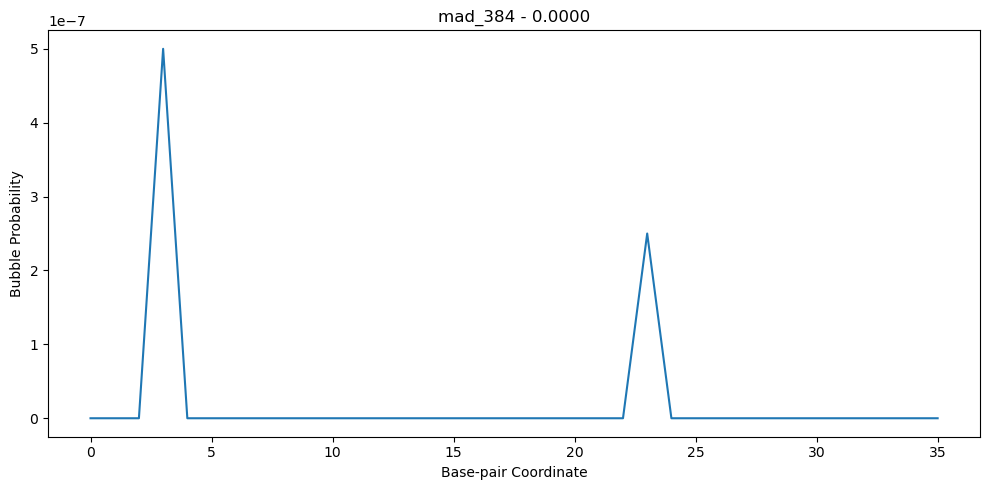

In [16]:
for n, item in lowest_values:
    min_key = list(item.keys())[0]
    min_value = list(item.values())[0]
    min_value_formatted = "{:.4f}".format(min_value)  # Restrict to 4 decimal places
    plt.figure(figsize=(10, 5))
    # plot a line curve
    plt.plot(agnosticset[min_key])
    plt.title(f'{min_key} - {min_value_formatted}')
    plt.xlabel('Base-pair Coordinate')
    plt.ylabel('Bubble Probability')
    # remove whitespace from the figure
    plt.tight_layout()
    plt.show()

In [17]:
# flatten all the bubble values for each sequence in each tf dictionary
mad_bubble = []
for i in mad_ids:
    mad_bubble.append(mad_data[i]['bubble'].flatten())
# flatten mad_bubble
mad_bubble = [item for sublist in mad_bubble for item in sublist]
mad_bubble = np.array(mad_bubble)
mad_percentile = np.percentile(mad_bubble, 95)
max_bubble = []
for i in max_ids:
    max_bubble.append(max_data[i]['bubble'].flatten())
# flatten max_bubble
max_bubble = [item for sublist in max_bubble for item in sublist]
max_bubble = np.array(max_bubble)
max_percentile = np.percentile(max_bubble, 95)
myc_bubble = []
for i in myc_ids:
    myc_bubble.append(myc_data[i]['bubble'].flatten())
# flatten myc_bubble
myc_bubble = [item for sublist in myc_bubble for item in sublist]
myc_bubble = np.array(myc_bubble)
myc_percentile = np.percentile(myc_bubble, 95)

print(mad_percentile, max_percentile, myc_percentile)

0.000140875 0.000149125 0.0001425


In [18]:
for tf in [mad_data, max_data, myc_data]:
    if tf == mad_data:
        name = 'mad'
        value_set = mad_percentile
    elif tf == max_data:
        name = 'max'
        value_set = max_percentile
    else:
        name = 'myc'
        value_set = myc_percentile
    arrays = 0
    for bubble in agnosticset.keys():
        if name in bubble:
            if np.max(agnosticset[bubble]) > value_set:
                arrays += 1

    print(f'Total arrays: {len(tf.keys())}')
    print(f'Arrays with a maximum value greater than {value_set:.4f} at timepoint 0: {arrays}')
    print(f'Percentage of arrays with a maximum value greater than {value_set:.4f} at timepoint 0: {arrays/len(tf.keys())*100:.2f}%')

Total arrays: 7534
Arrays with a maximum value greater than 0.0001 at timepoint 0: 1266
Percentage of arrays with a maximum value greater than 0.0001 at timepoint 0: 16.80%
Total arrays: 8568
Arrays with a maximum value greater than 0.0001 at timepoint 0: 1361
Percentage of arrays with a maximum value greater than 0.0001 at timepoint 0: 15.88%
Total arrays: 6926
Arrays with a maximum value greater than 0.0001 at timepoint 0: 1186
Percentage of arrays with a maximum value greater than 0.0001 at timepoint 0: 17.12%


In [19]:
for tf in [mad_data, max_data, myc_data]:
    if tf == mad_data:
        name = 'mad'
        value_set = mad_percentile
    elif tf == max_data:
        name = 'max'
        value_set = max_percentile
    else:
        name = 'myc'
        value_set = myc_percentile
    arrays = 0
    for bubble in agnosticset.keys():
        if name in bubble:
            if np.max(agnosticset[bubble]) > value_set:
                tf[int(bubble.split('_')[1])]['bubble_binary'] = 1
            else:
                tf[int(bubble.split('_')[1])]['bubble_binary'] = 0

In [20]:
tf_label = {}
tf_bubble_binary = {}
for tf in [mad_data, max_data, myc_data]:
    if tf == mad_data:
        name = 'mad'
    elif tf == max_data:
        name = 'max'
    else:
        name = 'myc'
    tf_label[name] = []
    tf_bubble_binary[name] = []
    for seq_id in tf.keys():
        tf_label[name].append(tf[seq_id]['label'])
        tf_bubble_binary[name].append(tf[seq_id]['bubble_binary'])

In [21]:
# divide the tf_label data into bubble positive and bubble negative data
mad_label_bubble_pos = []
mad_label_bubble_neg = []
for n, i in enumerate(tf_label['mad']):
    if tf_bubble_binary['mad'][n] == 1:
        mad_label_bubble_pos.append(i)
    else:
        mad_label_bubble_neg.append(i)

max_label_bubble_pos = []
max_label_bubble_neg = []
for n, i in enumerate(tf_label['max']):
    if tf_bubble_binary['max'][n] == 1:
        max_label_bubble_pos.append(i)
    else:
        max_label_bubble_neg.append(i)

myc_label_bubble_pos = []
myc_label_bubble_neg = []
for n, i in enumerate(tf_label['myc']):
    if tf_bubble_binary['myc'][n] == 1:
        myc_label_bubble_pos.append(i)
    else:
        myc_label_bubble_neg.append(i)

In [22]:
# run a t-test on the bubble positive and bubble negative data for each TF
print('MAD')
t_stat, p_val = stats.ttest_ind(mad_label_bubble_pos, mad_label_bubble_neg)
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_val}')
print()
print('MAX')
t_stat, p_val = stats.ttest_ind(max_label_bubble_pos, max_label_bubble_neg)
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_val}')
print()
print('MYC')
t_stat, p_val = stats.ttest_ind(myc_label_bubble_pos, myc_label_bubble_neg)
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_val}')

MAD
T-statistic: 3.0415
P-value: 0.0023625157500119496

MAX
T-statistic: 4.5823
P-value: 4.663198015900617e-06

MYC
T-statistic: 1.5249
P-value: 0.1273411464685596


In [23]:
from scipy.stats import mannwhitneyu

print('MAD')
u_statistic, p_value = mannwhitneyu(mad_label_bubble_pos, mad_label_bubble_neg)
print(f'U Statistic: {u_statistic:.4f}')
print(f'P-Value: {p_value}')
print()

print('MAX')
u_statistic, p_value = mannwhitneyu(max_label_bubble_pos, max_label_bubble_neg)
print(f'U Statistic: {u_statistic:.4f}')
print(f'P-Value: {p_value}')
print()

print('MYC')
u_statistic, p_value = mannwhitneyu(myc_label_bubble_pos, myc_label_bubble_neg)
print(f'U Statistic: {u_statistic:.4f}')
print(f'P-Value: {p_value}')

MAD
U Statistic: 4410794.5000
P-Value: 3.430484717720097e-10

MAX
U Statistic: 5564323.5000
P-Value: 3.129469915381394e-15

MYC
U Statistic: 3577091.0000
P-Value: 0.005709047733220515


In [24]:
import matplotlib.pyplot as plt

for tf in ['mad', 'max', 'myc']:
    # Sample data for illustration purposes
    label_bubble_pos = locals()[f"{tf}_label_bubble_pos"]
    label_bubble_neg = locals()[f"{tf}_label_bubble_neg"]

In [25]:
for tf in ['mad', 'max', 'myc']:
    # Sample data for illustration purposes
    label_bubble_pos = locals()[f"{tf}_label_bubble_pos"]
    label_bubble_neg = locals()[f"{tf}_label_bubble_neg"]

    # Combine the data into a DataFrame with a new column for the type (positive/negative)
    data_df = pd.DataFrame({'Label Values': label_bubble_pos + label_bubble_neg,
                            'Bubble': ['Bubble Positive'] * len(label_bubble_pos) + ['Bubble Negative'] * len(label_bubble_neg)})

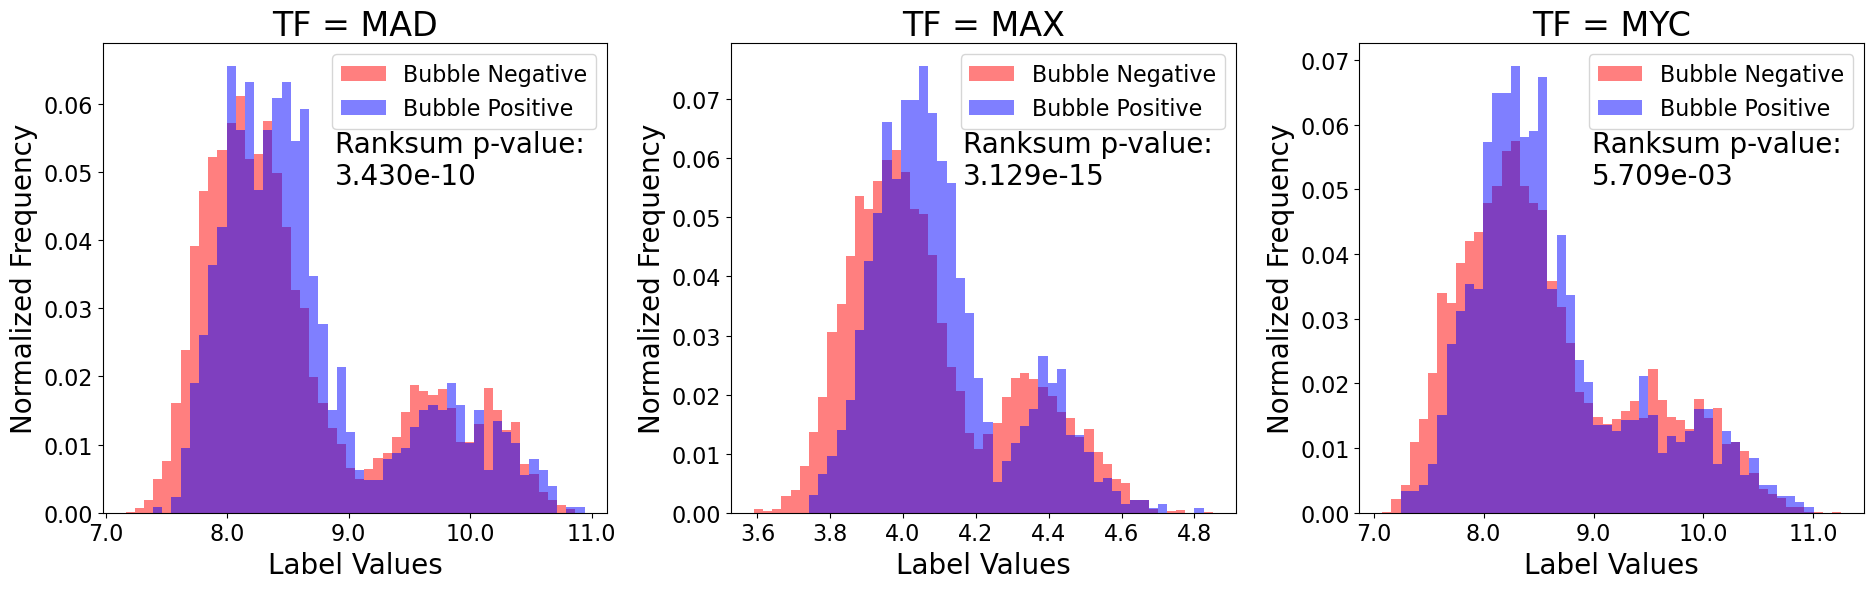

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ranksums
from matplotlib.ticker import FormatStrFormatter

title_fontsize = 24
label_fontsize = 20
tick_fontsize = 16  # Adjust tick font size

fig, axes = plt.subplots(1, 3, figsize=(19, 6))

# Formatter for x-ticks to show 1 decimal place
formatter = FormatStrFormatter('%.1f')

for i, tf in enumerate(['mad', 'max', 'myc']):
    label_bubble_pos = locals()[f"{tf}_label_bubble_pos"]
    label_bubble_neg = locals()[f"{tf}_label_bubble_neg"]

    # ranksum test
    u_statistic, p_value = ranksums(label_bubble_pos, label_bubble_neg)

    # Combine the data to calculate the shared bins
    combined_data = np.concatenate((label_bubble_pos, label_bubble_neg))

    # Calculate the combined histogram bins
    combined_counts, combined_bins = np.histogram(combined_data, bins=50)

    # Calculate histograms using the shared bins
    pos_counts, _ = np.histogram(label_bubble_pos, bins=combined_bins)
    neg_counts, _ = np.histogram(label_bubble_neg, bins=combined_bins)

    # normalize counts
    pos_normalized = pos_counts / len(label_bubble_pos)
    neg_normalized = neg_counts / len(label_bubble_neg)

    # Plot the normalized histograms
    bar_width = (combined_bins[1] - combined_bins[0])  # Adjust width to ensure overlapping
    axes[i].bar(combined_bins[:-1], neg_normalized, width=bar_width, color='red', alpha=0.5, label='Bubble Negative')
    axes[i].bar(combined_bins[:-1], pos_normalized, width=bar_width, color='blue', alpha=0.5, label='Bubble Positive')

    # Add the ranksum test results to the plot
    axes[i].text(0.46, 0.7, f'Ranksum p-value:\n{p_value:.3e}', fontsize=20, ha='left', transform=axes[i].transAxes)
    
    axes[i].set_title('TF = ' + f"{tf}".upper(), fontsize=title_fontsize)
    axes[i].set_xlabel("Label Values", fontsize=label_fontsize)
    axes[i].set_ylabel("Normalized Frequency", fontsize=label_fontsize)
    axes[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[i].legend(fontsize=tick_fontsize)

    # Apply the formatter to the x-axis
    axes[i].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('/scratch/midway3/waqaas/DNA-breathing/figs/paper/bubble_pos_neg_hist2new.png')
plt.show()


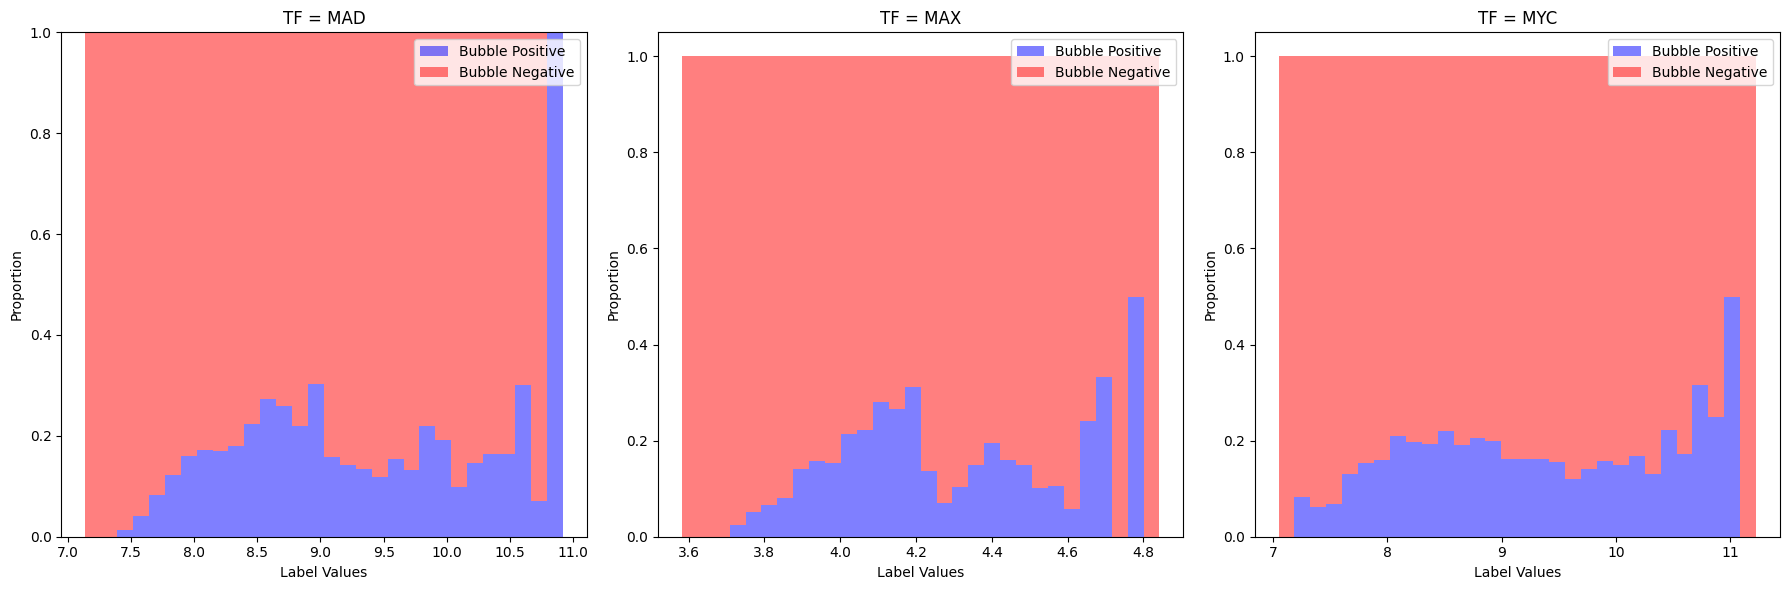

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, tf in enumerate(['mad', 'max', 'myc']):
    label_bubble_pos = locals()[f"{tf}_label_bubble_pos"]
    label_bubble_neg = locals()[f"{tf}_label_bubble_neg"]

    # Combine the data to calculate the shared bins
    combined_data = np.concatenate((label_bubble_pos, label_bubble_neg))

    # Calculate the combined histogram bins
    combined_counts, combined_bins = np.histogram(combined_data, bins=30)

    # Calculate histograms using the shared bins
    pos_counts, _ = np.histogram(label_bubble_pos, bins=combined_bins)
    neg_counts, _ = np.histogram(label_bubble_neg, bins=combined_bins)

    # Calculate the total number of samples in each bin
    total_counts = pos_counts + neg_counts

    # Calculate the proportions
    pos_proportion = pos_counts / total_counts
    neg_proportion = neg_counts / total_counts

    # Plot the stacked bar plot
    bar_width = (combined_bins[1] - combined_bins[0])  # Adjust width to ensure overlapping
    axes[i].bar(combined_bins[:-1], pos_proportion, width=bar_width, color='blue', alpha=0.5, label='Bubble Positive')
    axes[i].bar(combined_bins[:-1], neg_proportion, width=bar_width, bottom=pos_proportion, color='red', alpha=0.5, label='Bubble Negative')

    axes[i].set_title('TF = ' + f"{tf}".upper())
    axes[i].set_xlabel("Label Values")
    axes[i].set_ylabel("Proportion")
    axes[i].legend()

plt.tight_layout()
plt.savefig('/scratch/midway3/waqaas/DNA-breathing/figs/paper/bubble_pos_neg_hist_stacked.png')
plt.show()
